# Unit15_Example | Red Wine Quality：以 DNN 預測紅酒品質（回歸）

本 Notebook 使用 `Part_4/data/redwine/winequality-red.csv` 建立回歸型 DNN（MLP）模型來預測紅酒品質分數。

## 目標
- 建立 baseline（Ridge）與 DNN 的效果對照
- 示範正確資料切分與標準化（避免 data leakage）
- 以 MAE / RMSE / R2 評估模型
- 分析特徵重要性

資料背景可參考 Kaggle：https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/data


---
### 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit15_Example_RedWine'
SOURCE_DATA_DIR = 'redwine'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\data\redwine
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_RedWine
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_RedWine\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_RedWine\figs

TensorFlow Version: 2.10.0
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
### 數據下載

In [2]:
# 數據來源: Kaggle Red Wine Quality Dataset
# https://www.kaggle.com/api/v1/datasets/download/uciml/red-wine-quality-cortez-et-al-2009

import requests
import os
import zipfile

# 1. 設定路徑與 URL
url = "https://www.kaggle.com/api/v1/datasets/download/uciml/red-wine-quality-cortez-et-al-2009"
zip_path = os.path.join(DATA_DIR, "red-wine-quality-cortez-et-al-2009.zip")
data_file = os.path.join(DATA_DIR, "winequality-red.csv")
extract_path = DATA_DIR

def download_and_extract():
    # --- 步驟 A: 下載檔案 ---
    print(f"正在從 {url} 下載...")
    try:
        # allow_redirects=True 處理 Kaggle 的重導向
        response = requests.get(url, allow_redirects=True, stream=True)
        response.raise_for_status() # 若下載失敗會拋出異常
        
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"下載成功，檔案儲存於: {zip_path}")

        # --- 步驟 B: 解壓縮檔案 ---
        if zipfile.is_zipfile(zip_path):
            print(f"正在解壓縮至: {extract_path}...")
            # 確保目標資料夾存在
            if not os.path.exists(extract_path):
                os.makedirs(extract_path)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            
            print("解壓縮完成！")
            
            # (選填) 步驟 C: 刪除原始 ZIP 檔以節省空間
            # os.remove(zip_path)
            # print("已移除原始 ZIP 壓縮檔。")
        else:
            print("錯誤：下載的檔案不是有效的 ZIP 格式。")
            
    except Exception as e:
        print(f"發生錯誤: {e}")

if __name__ == "__main__" and not os.path.exists(data_file):
    download_and_extract()
else:
    print(f"檔案已存在於: {data_file}")

檔案已存在於: d:\MyGit\CHE-AI-COURSE\Part_4\data\redwine\winequality-red.csv


In [3]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import joblib, pickle, json
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

print(f"TensorFlow版本: {tf.__version__}")
print(f"Keras版本: {keras.__version__}")

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(seed=None)
tf.random.set_seed(seed=None)

# 設定matplotlib中文顯示
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial'] # Colab不支援
plt.rcParams['axes.unicode_minus'] = False

TensorFlow版本: 2.10.0
Keras版本: 2.10.0


## 1) 讀取資料與快速檢查

- 資料包含 11 個理化特徵 + 1 個目標（quality）
- 共 1599 筆樣本

In [4]:
df = pd.read_csv(DATA_DIR / "winequality-red.csv")

print("Data shape:", df.shape)
display(df.head())

print("\nMissing values:")
display(df.isna().sum())

print("\nTarget (quality) summary:")
display(df["quality"].describe())

print("\nQuality value counts:")
display(df["quality"].value_counts().sort_index())

Data shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



Missing values:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Target (quality) summary:


count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64


Quality value counts:


quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

## 2) EDA：品質分佈與相關性分析

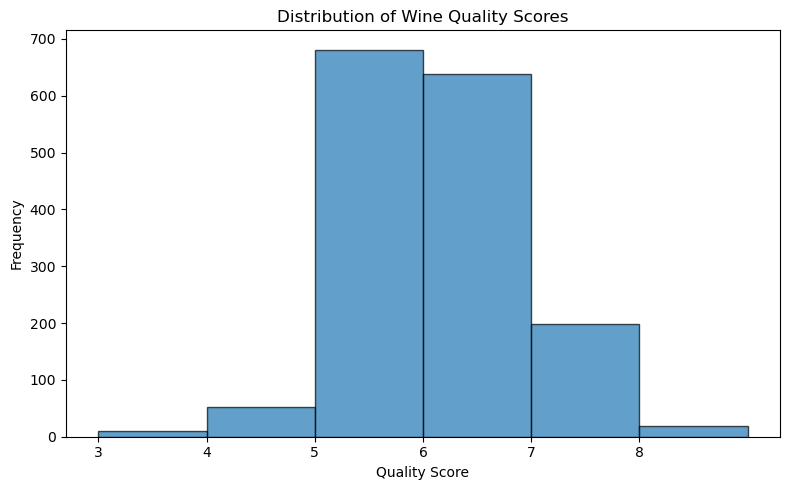

In [5]:
# 品質分數分佈
plt.figure(figsize=(8, 5))
plt.hist(df["quality"], bins=range(3, 10), edgecolor="black", alpha=0.7)
plt.xlabel("Quality Score")
plt.ylabel("Frequency")
plt.title("Distribution of Wine Quality Scores")
plt.xticks(range(3, 9))
plt.tight_layout()
plt.savefig(FIG_DIR / "quality_dist.png")
plt.show()

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

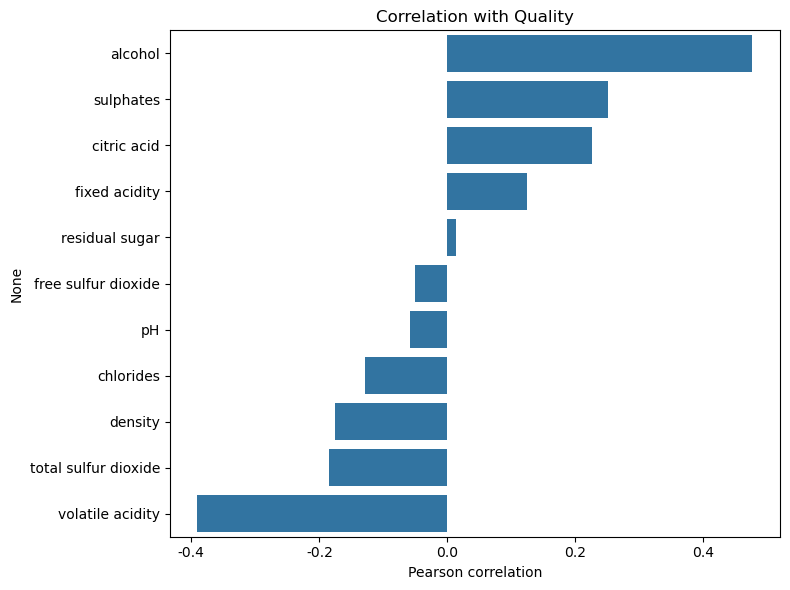

In [6]:
# 計算與 quality 的相關係數
corr = df.corr(numeric_only=True)["quality"].sort_values(ascending=False)
display(corr)

# 視覺化
plt.figure(figsize=(8, 6))
sns.barplot(x=corr.drop("quality").values, y=corr.drop("quality").index, orient="h")
plt.title("Correlation with Quality")
plt.xlabel("Pearson correlation")
plt.tight_layout()
plt.savefig(FIG_DIR / "corr_bar.png")
plt.show()

## 3) 資料切分與標準化（避免 Data Leakage）

流程：
1. 分離特徵 `X` 與目標 `y`（`quality`）
2. 切分成 train/valid/test = 70%/15%/15%
3. `StandardScaler` 僅使用訓練集 `fit`，再對 valid/test 做 `transform`

In [17]:
target_col = "quality"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].to_numpy(dtype=np.float32)
y = df[target_col].to_numpy(dtype=np.float32)

y_binned = pd.cut(y, bins=3, labels=False)

# train : valid : test = 70% : 15% : 15%
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y_binned
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEED
)

# 標準化 X (特徵)
scaler_X = StandardScaler()
scaler_X.fit_transform(X)
X_s = scaler_X.transform(X)
X_train_s = scaler_X.transform(X_train)
X_valid_s = scaler_X.transform(X_valid)
X_test_s = scaler_X.transform(X_test)

# 標準化 y (目標變數)
scaler_y = StandardScaler()
scaler_y.fit_transform(y.reshape(-1, 1))
y_train_s = scaler_y.transform(y_train.reshape(-1, 1)).reshape(-1)
y_valid_s = scaler_y.transform(y_valid.reshape(-1, 1)).reshape(-1)
y_test_s = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

print("X_train:", X_train_s.shape)
print("X_valid:", X_valid_s.shape)
print("X_test :", X_test_s.shape)
print("\ny_train:", y_train_s.shape)
print("y_valid:", y_valid_s.shape)
print("y_test :", y_test_s.shape)
print(f"\ny mean: {scaler_y.mean_[0]:.3f}, std: {scaler_y.scale_[0]:.3f}")

X_train: (1119, 11)
X_valid: (240, 11)
X_test : (240, 11)

y_train: (1119,)
y_valid: (240,)
y_test : (240,)

y mean: 5.636, std: 0.807


## 4) Baseline：Ridge Regression

建立一個快速 baseline，作為 DNN 是否值得的比較基準。

In [18]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)
train_pred_ridge = ridge.predict(X_train_s)
valid_pred_ridge = ridge.predict(X_valid_s)
test_pred_ridge = ridge.predict(X_test_s)
all_pred_ridge = ridge.predict(X_s)

train_mae_r = float(mean_absolute_error(y_train, train_pred_ridge))
train_rmse_r = float(np.sqrt(mean_squared_error(y_train, train_pred_ridge)))
train_r2_r = float(r2_score(y_train, train_pred_ridge))

val_mae_r = float(mean_absolute_error(y_valid, valid_pred_ridge))
val_rmse_r = float(np.sqrt(mean_squared_error(y_valid, valid_pred_ridge)))
val_r2_r = float(r2_score(y_valid, valid_pred_ridge))

test_mae_r = float(mean_absolute_error(y_test, test_pred_ridge))
test_rmse_r = float(np.sqrt(mean_squared_error(y_test, test_pred_ridge)))
test_r2_r = float(r2_score(y_test, test_pred_ridge))

all_mae_r = float(mean_absolute_error(y, all_pred_ridge))
all_rmse_r = float(np.sqrt(mean_squared_error(y, all_pred_ridge)))
all_r2_r = float(r2_score(y, all_pred_ridge))

metrics_ridge = pd.DataFrame(
    {
    "train_mae": train_mae_r,
    "train_rmse": train_rmse_r,
    "train_r2": train_r2_r,
    "valid_mae": val_mae_r,
    "valid_rmse": val_rmse_r,
    "valid_r2": val_r2_r,
    "test_mae": test_mae_r,
    "test_rmse": test_rmse_r,
    "test_r2": test_r2_r,
    "all_mae": all_mae_r,
    "all_rmse": all_rmse_r,
    "all_r2": all_r2_r
    },index=["Ridge"],
    )

print(metrics_ridge)

       train_mae  train_rmse  train_r2  valid_mae  valid_rmse  valid_r2  \
Ridge    0.49879    0.647412  0.357823   0.526693    0.675266  0.330239   

       test_mae  test_rmse   test_r2   all_mae  all_rmse    all_r2  
Ridge  0.482231   0.618456  0.372523  0.500492  0.647434  0.356865  


## 5) DNN（MLP）回歸模型

重點：
- 多層 Dense（全連接）：64 -> 32 -> 16
- ReLU 激活函數
- EarlyStopping 避免過擬合

In [9]:
# 建立模型
keras.backend.clear_session()
model = keras.Sequential(
    [
        Input(shape=(X_train_s.shape[1],)),
        Dense(128, activation="elu"),
        Dense(64, activation="elu"),
        Dense(32, activation="elu"),
        Dense(16, activation="elu"),
        Dense(1),
    ]
)

# 編譯模型
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae', 'mse'],
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________


In [10]:

callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=30, restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss", patience=10, factor=0.5, min_lr=1e-6
    ),
]


history = model.fit(
    X_train_s,
    y_train,
    validation_data=(X_valid_s, y_valid),
    epochs=500,
    batch_size=16,
    callbacks=callbacks,
    verbose=1,
)


Epoch 1/500
70/70 [==============================] - 1s 9ms/step - loss: 11.2520 - mae: 2.7074 - mse: 11.2520 - val_loss: 1.3934 - val_mae: 0.9523 - val_mse: 1.3934 - lr: 0.0010
Epoch 2/500
70/70 [==============================] - 0s 4ms/step - loss: 0.9145 - mae: 0.7287 - mse: 0.9145 - val_loss: 0.7965 - val_mae: 0.6979 - val_mse: 0.7965 - lr: 0.0010
Epoch 3/500
70/70 [==============================] - 0s 4ms/step - loss: 0.5896 - mae: 0.5879 - mse: 0.5896 - val_loss: 0.6836 - val_mae: 0.6356 - val_mse: 0.6836 - lr: 0.0010
Epoch 4/500
70/70 [==============================] - 0s 4ms/step - loss: 0.5282 - mae: 0.5669 - mse: 0.5282 - val_loss: 0.5900 - val_mae: 0.5813 - val_mse: 0.5900 - lr: 0.0010
Epoch 5/500
70/70 [==============================] - 0s 4ms/step - loss: 0.4619 - mae: 0.5241 - mse: 0.4619 - val_loss: 0.5671 - val_mae: 0.5886 - val_mse: 0.5671 - lr: 0.0010
Epoch 6/500
70/70 [==============================] - 0s 4ms/step - loss: 0.4326 - mae: 0.5122 - mse: 0.4326 - val_loss

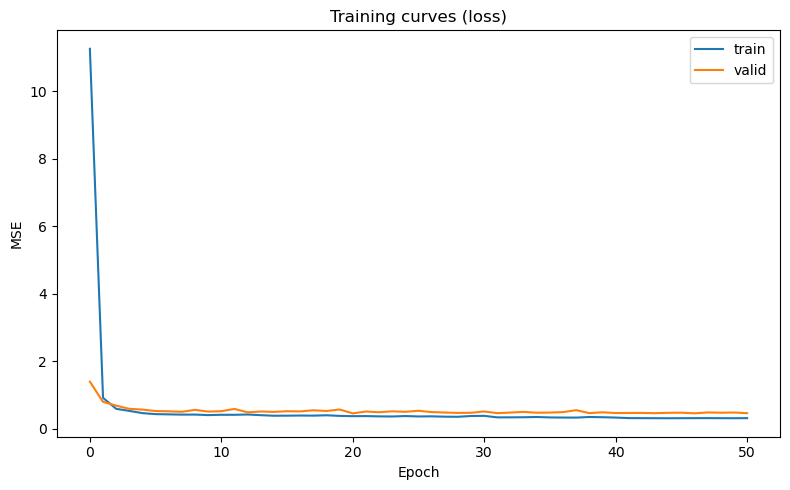

In [11]:
# 訓練曲線
hist = pd.DataFrame(history.history)
plt.figure(figsize=(8, 5))
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="valid")
plt.title("Training curves (loss)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "loss_curve.png")
plt.show()

## 6) 評估：MAE / RMSE / R2 + Parity plot

In [19]:
train_pred_dnn = model.predict(X_train_s, verbose=0).reshape(-1)
valid_pred_dnn = model.predict(X_valid_s, verbose=0).reshape(-1)
test_pred_dnn = model.predict(X_test_s, verbose=0).reshape(-1)
all_pred_dnn = model.predict(X_s, verbose=0).reshape(-1)

train_mae = float(mean_absolute_error(y_train, train_pred_dnn))
train_rmse = float(np.sqrt(mean_squared_error(y_train, train_pred_dnn)))
train_r2 = float(r2_score(y_train, train_pred_dnn))

valid_mae = float(mean_absolute_error(y_valid, valid_pred_dnn))
valid_rmse = float(np.sqrt(mean_squared_error(y_valid, valid_pred_dnn)))
valid_r2 = float(r2_score(y_valid, valid_pred_dnn))

test_mae = float(mean_absolute_error(y_test, test_pred_dnn))
test_rmse = float(np.sqrt(mean_squared_error(y_test, test_pred_dnn)))
test_r2 = float(r2_score(y_test, test_pred_dnn))

all_mae = float(mean_absolute_error(y, all_pred_dnn))
all_rmse = float(np.sqrt(mean_squared_error(y, all_pred_dnn)))
all_r2 = float(r2_score(y, all_pred_dnn))

# create a datafram contains DNN training, validation, testing metrics
metrics_dnn = pd.DataFrame(
    {
        "train_mae": train_mae,
        "train_rmse": train_rmse,
        "train_r2": train_r2,
        "valid_mae": valid_mae,
        "valid_rmse": valid_rmse,
        "valid_r2": valid_r2,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "all_mae": all_mae,
        "all_rmse": all_rmse,
        "all_r2": all_r2,
    },
    index=["DNN"],
)

# combine metrics
metrics = pd.concat([metrics_ridge, metrics_dnn])
print(metrics)

# 保存指標 save metrics
metrics.to_json(MODEL_DIR / "metrics.json")



       train_mae  train_rmse  train_r2  valid_mae  valid_rmse  valid_r2  \
Ridge   0.498790    0.647412  0.357823   0.526693    0.675266  0.330239   
DNN     0.453641    0.589128  0.468244   0.515848    0.674218  0.332315   

       test_mae  test_rmse   test_r2   all_mae  all_rmse    all_r2  
Ridge  0.482231   0.618456  0.372523  0.500492  0.647434  0.356865  
DNN    0.468102   0.610326  0.388912  0.465148  0.605824  0.436875  


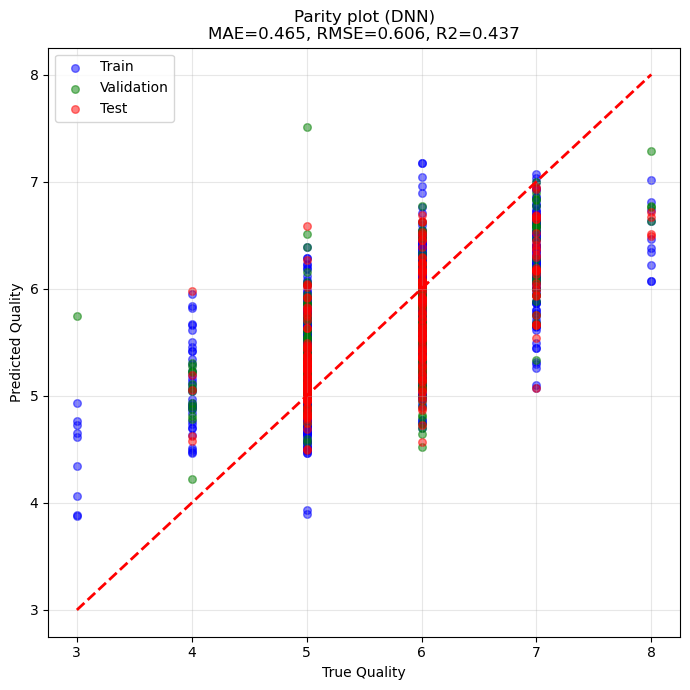

In [23]:
# Parity plot
plt.figure(figsize=(7, 7))
plt.scatter(y_train, train_pred_dnn, alpha=0.5, s=30, label="Train", color="blue")
plt.scatter(y_valid, valid_pred_dnn, alpha=0.5, s=30, label="Validation", color="green")
plt.scatter(y_test, test_pred_dnn, alpha=0.5, s=30, label="Test", color="red")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("True Quality")
plt.ylabel("Predicted Quality")
plt.title(f"Parity plot (DNN)\nMAE={all_mae:.3f}, RMSE={all_rmse:.3f}, R2={all_r2:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "parity_plot_dnn.png")
plt.show()

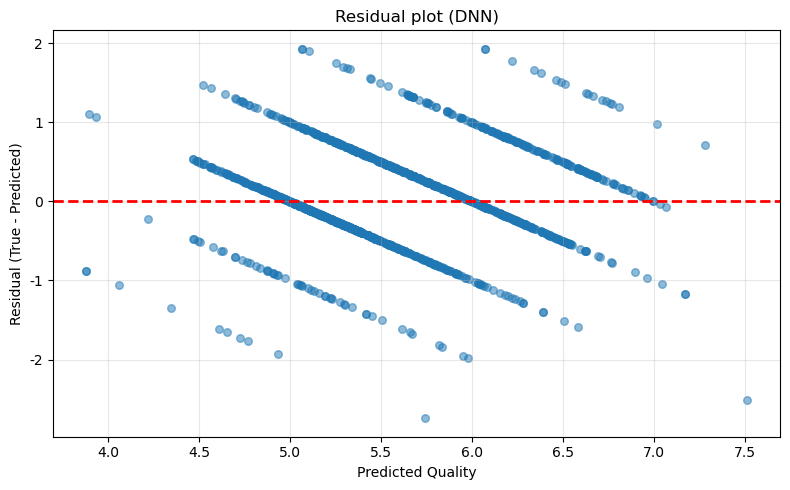

In [24]:
# Residual plot
residuals = y - all_pred_dnn

plt.figure(figsize=(8, 5))
plt.scatter(all_pred_dnn, residuals, alpha=0.5, s=30)
plt.axhline(y=0, color="r", linestyle="--", lw=2)
plt.xlabel("Predicted Quality")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual plot (DNN)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "residual_plot.png")
plt.show()

## 7) 特徵重要性分析（Permutation Importance）

Feature Importance (Permutation):


,feature,importance
10,alcohol,0.232871
1,volatile acidity,0.120648
9,sulphates,0.062244
6,total sulfur dioxide,0.025746
0,fixed acidity,0.011917
4,chlorides,0.010786
7,density,0.005101
2,citric acid,0.004808
5,free sulfur dioxide,0.003988
3,residual sugar,0.001474


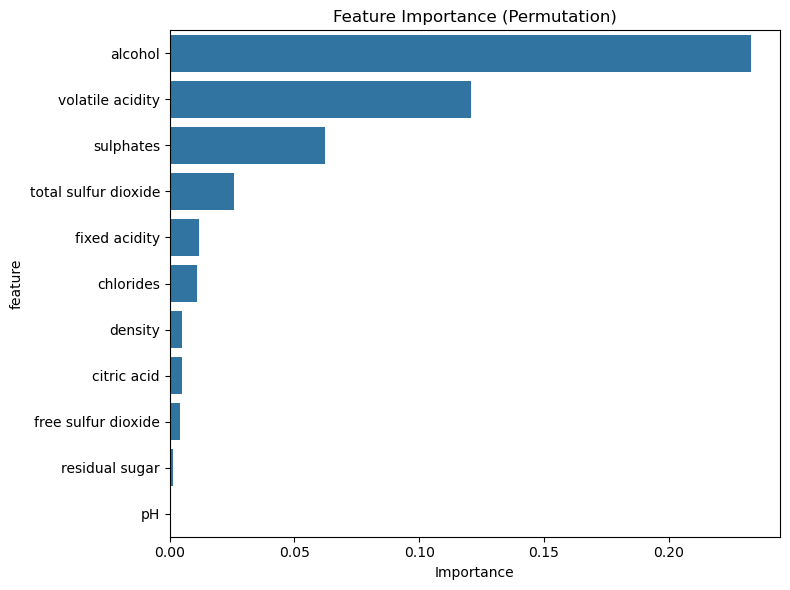

In [25]:
# 使用 Ridge 模型計算 Permutation Importance（DNN 計算較慢）
perm_importance = permutation_importance(
    ridge, X_test_s, y_test_s, n_repeats=10, random_state=SEED, n_jobs=-1
)

importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": perm_importance.importances_mean,
}).sort_values("importance", ascending=False)

print("Feature Importance (Permutation):")
display(importance_df)

# 視覺化
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x="importance", y="feature", orient="h")
plt.title("Feature Importance (Permutation)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_importance.png")
plt.show()

## 8) 保存模型與 Scaler

In [26]:
# 保存 X scaler
scaler_X_path = MODEL_DIR / "scaler_X.pkl"
joblib.dump(scaler_X, scaler_X_path)
print(f"Saved X scaler: {scaler_X_path}")

# 保存 y scaler
scaler_y_path = MODEL_DIR / "scaler_y.pkl"
joblib.dump(scaler_y, scaler_y_path)
print(f"Saved y scaler: {scaler_y_path}")

# 保存模型
model_path = MODEL_DIR / "dnn_model.keras"
model.save(model_path)
print(f"Saved model: {model_path}")

# 保存 Ridge baseline
ridge_path = MODEL_DIR / "ridge_model.pkl"
joblib.dump(ridge, ridge_path)
print(f"Saved Ridge: {ridge_path}")

Saved X scaler: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_RedWine\models\scaler_X.pkl
Saved y scaler: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_RedWine\models\scaler_y.pkl
Saved model: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_RedWine\models\dnn_model.keras
Saved Ridge: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_RedWine\models\ridge_model.pkl


## 總結

本 Notebook 示範了：
1. 紅酒品質資料的 EDA 與相關性分析
2. 正確的資料切分與標準化流程
3. Ridge baseline 的建立
4. DNN（MLP）回歸模型的訓練與評估
5. 特徵重要性分析

### 主要發現：
- **alcohol**（酒精度）與品質呈最強正相關
- **volatile acidity**（揮發性酸度）與品質呈最強負相關
- DNN 相較於 Ridge 有明顯改善（R² 從 ~0.36 提升到 ~0.54）
- 品質分數主要集中在 5-6 分，存在類別不平衡問題

### 延伸練習：
1. 嘗試不同的網路架構（層數、神經元數）
2. 加入 Dropout 或 BatchNormalization
3. 將問題轉為分類（低/中/高品質）
4. 處理類別不平衡問題（SMOTE、class weights）
5. 使用 SHAP 進行更深入的特徵重要性分析